In [3]:
# | default_exp _components.mono_dense_layer

# Monotonic dense layer

> Implementation of the MonoDense layer

## Imports

In [4]:
# | export

from contextlib import contextmanager
from datetime import datetime
from functools import lru_cache
from typing import *

import numpy as np
import tensorflow as tf
from numpy.typing import ArrayLike, NDArray
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.types.experimental import TensorLike

from airt._components.helpers import export

In [5]:
from os import environ
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pytest
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [6]:
environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Monotonic Dense Layer


### Actvation Functions

We use $\breve{\mathcal{A}}$ to denote the set of all zero-centred, monotonically increasing, convex, lower-bounded functions.

Let $\breve{\rho} \in \breve{\mathcal{A}}$. Then
\begin{align}\label{eq:activation_concave}
    \hat{\rho}(x) & = -\breve{\rho}(-x) \\
    \label{eq:activation_saturated}
    \tilde{\rho}(x) & = \begin{cases}
      \breve{\rho}(x+1)-\breve{\rho}(1) & \text{if }x < 0\\
      \hat{\rho}(x-1)+\breve{\rho}(1) & \text{otherwise}
    \end{cases} 
\end{align}
 
 In the code below, the following names are used for denotation of the above functions:
 
 - `convex_activation` denotes $\breve{\rho}$,
 
 - `concave_activation` denotes $\hat{\rho}$, and
 
 - `saturated_activation` denotes $\tilde{\rho}$. 
 

In [ ]:
# | export


def get_saturated_activation(
    convex_activation: Callable[[TensorLike], TensorLike],
    concave_activation: Callable[[TensorLike], TensorLike],
    a: float = 1.0,
    c: float = 1.0,
) -> Callable[[TensorLike], TensorLike]:
    @tf.function
    def saturated_activation(
        x: TensorLike,
        convex_activation: Callable[[TensorLike], TensorLike] = convex_activation,
        concave_activation: Callable[[TensorLike], TensorLike] = concave_activation,
        a: float = a,
        c: float = c,
    ) -> TensorLike:
        cc = convex_activation(tf.ones_like(x) * c)
        ccc = concave_activation(-tf.ones_like(x) * c)
        return a * tf.where(
            x <= 0,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )

    return saturated_activation  # type: ignore


@lru_cache
def get_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None
) -> Tuple[
    Callable[[TensorLike], TensorLike],
    Callable[[TensorLike], TensorLike],
    Callable[[TensorLike], TensorLike],
]:
    convex_activation = tf.keras.activations.get(
        activation.lower() if isinstance(activation, str) else activation
    )

    @tf.function
    def concave_activation(x: TensorLike) -> TensorLike:
        return -convex_activation(-x)

    saturated_activation = get_saturated_activation(
        convex_activation, concave_activation
    )
    return convex_activation, concave_activation, saturated_activation

In [ ]:
# | hide


for activation in [None, "relu", tf.keras.activations.elu]:
    f, g, h = get_activation_functions(activation)
    hasattr(f, "__call__")
    hasattr(g, "__call__")
    hasattr(h, "__call__")

In [ ]:
# | hide


def plot_activation_functions(
    activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    *,
    font_size: int = 20,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    linestyle="--",
    alpha=0.7,
    linewidth=4.0,
) -> None:
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)
    plt.rcParams["figure.figsize"] = (6, 4)

    x = np.arange(-3.5, 3.5, 0.1)
    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    plt.plot(x, convex_activation(x), label=r"$\breve{\rho}(x)$", **plot_kwargs)
    plt.plot(x, concave_activation(x), label=r"$\hat{\rho}(x)$", **plot_kwargs)
    plt.plot(x, saturated_activation(x), label=r"$\tilde{\rho}(x)$", **plot_kwargs)
    plt.legend()

    title = f"{activation.__name__ if hasattr(activation, '__name__') else activation}-based activations"
    plt.title(title)
    if save_pdf:
        for file_format in ["pdf", "png"]:
            path = Path(save_path) / (title.replace(" ", "_") + f".{file_format}")
            path.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(path, format=file_format)
            print(f"Saved figure to: {path}")

    plt.show()

2023-06-09 08:47:40.032380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-09 08:47:40.032419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 777faa4633a1
2023-06-09 08:47:40.032427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 777faa4633a1
2023-06-09 08:47:40.032546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-06-09 08:47:40.032572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.182.3


Saved figure to: plots/linear-based_activations.pdf
Saved figure to: plots/linear-based_activations.png


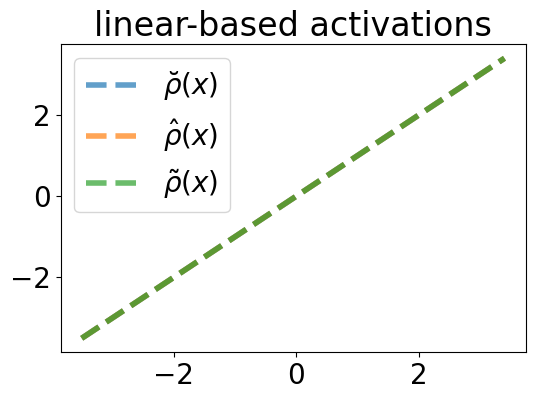

Saved figure to: plots/ReLU-based_activations.pdf
Saved figure to: plots/ReLU-based_activations.png


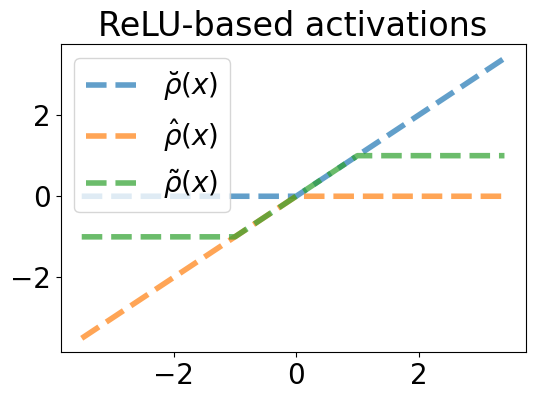

Saved figure to: plots/ELU-based_activations.pdf
Saved figure to: plots/ELU-based_activations.png


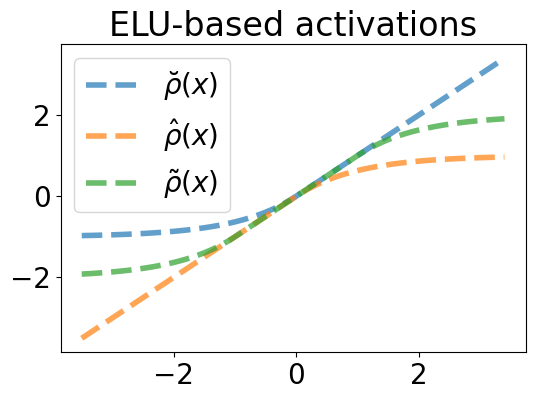

Saved figure to: plots/SELU-based_activations.pdf
Saved figure to: plots/SELU-based_activations.png


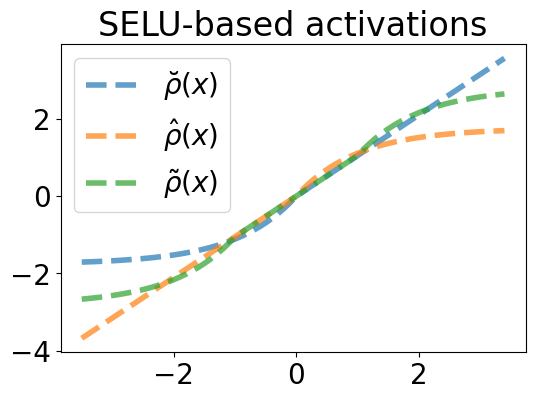

In [ ]:
# | hide


for activation in ["linear", "ReLU", "ELU", "SELU"]:
    plot_activation_functions(activation, save_pdf=True)

In [ ]:
# | export


@tf.function
def apply_activations(
    x: TensorLike,
    *,
    units: int,
    convex_activation: Callable[[TensorLike], TensorLike],
    concave_activation: Callable[[TensorLike], TensorLike],
    saturated_activation: Callable[[TensorLike], TensorLike],
    is_convex: bool = False,
    is_concave: bool = False,
    activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
) -> TensorLike:
    if convex_activation is None:
        return x

    elif is_convex:
        normalized_activation_weights = np.array([1.0, 0.0, 0.0])
    elif is_concave:
        normalized_activation_weights = np.array([0.0, 1.0, 0.0])
    else:
        if len(activation_weights) != 3:
            raise ValueError(f"activation_weights={activation_weights}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"activation_weights={activation_weights}")
        normalized_activation_weights = np.array(activation_weights) / sum(
            activation_weights
        )

    s_convex = round(normalized_activation_weights[0] * units)
    s_concave = round(normalized_activation_weights[1] * units)
    s_saturated = units - s_convex - s_concave

    x_convex, x_concave, x_saturated = tf.split(
        x, (s_convex, s_concave, s_saturated), axis=-1
    )

    y_convex = convex_activation(x_convex)
    y_concave = concave_activation(x_concave)
    y_saturated = saturated_activation(x_saturated)

    y = tf.concat([y_convex, y_concave, y_saturated], axis=-1)

    return y

In [ ]:
def plot_applied_activation(
    activation: str = "relu",
    *,
    save_pdf: bool = False,
    save_path: Union[Path, str] = "plots",
    font_size: int = 20,
    linestyle="--",
    alpha=0.7,
    linewidth=2.0,
):
    font = {"size": font_size}
    matplotlib.rc("font", **font)
    plt.rcParams["figure.figsize"] = (18, 3)

    x = np.arange(-1.5, 1.5, step=3 / 256)
    h = 3 * np.sin(2 * np.pi * x)

    (
        convex_activation,
        concave_activation,
        saturated_activation,
    ) = get_activation_functions(activation)

    y = apply_activations(
        h,
        convex_activation=convex_activation,
        concave_activation=concave_activation,
        saturated_activation=saturated_activation,
        units=x.shape[0],
        activation_weights=(1.0, 1.0, 1.0),
    )

    plot_kwargs = dict(linestyle=linestyle, alpha=alpha, linewidth=linewidth)

    plt.plot(np.arange(x.shape[0]), h, label="$h$", **plot_kwargs)
    plt.plot(np.arange(x.shape[0]), y, label=r"${\rho}(h)$", **plot_kwargs)
    title = (
        "Applying "
        + (activation.__name__ if hasattr(activation, "__name__") else activation)
        + f"-based activations to {x.shape[0]}-dimensional vector"
        + r" $h$"
    )
    plt.title(title)

    plt.legend()

    if save_pdf:
        path = Path(save_path) / (title.replace(" ", "_") + ".pdf")
        path.parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(path, format="pdf")
    #         print(f"Saved figure to: {path}")

    plt.show()

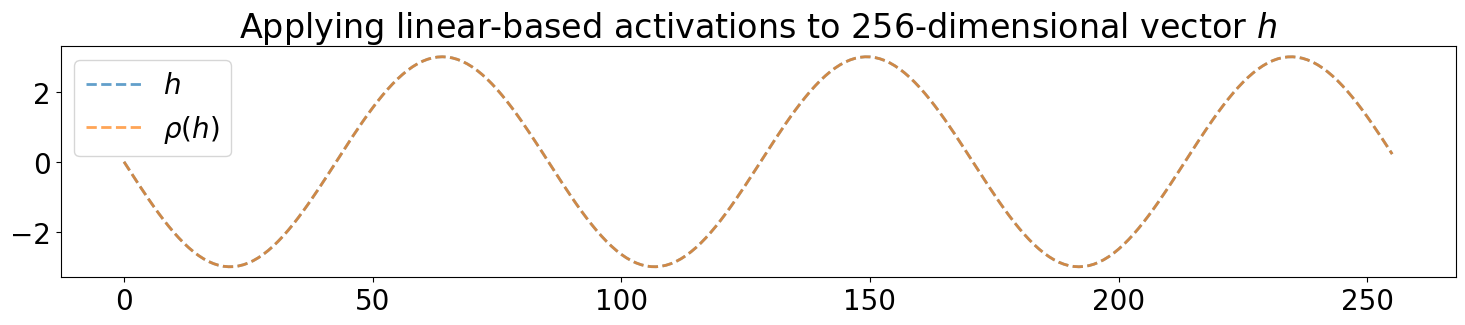

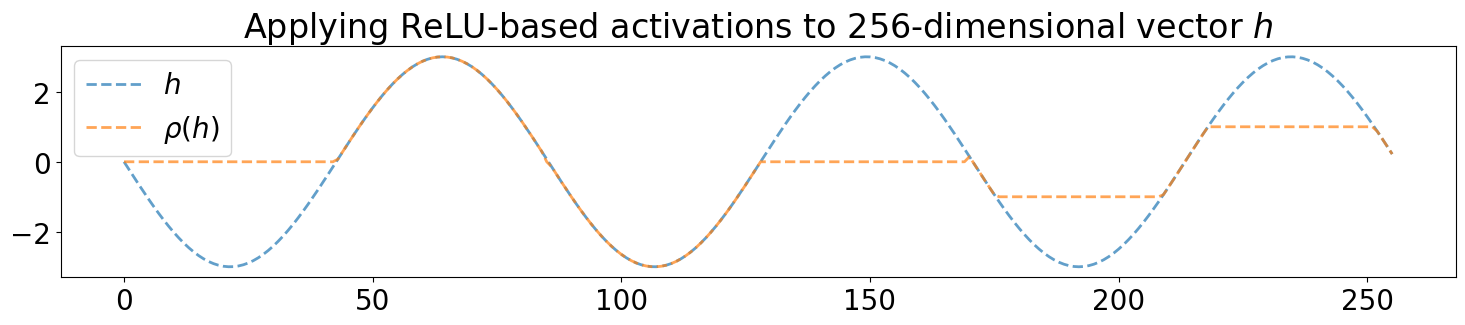

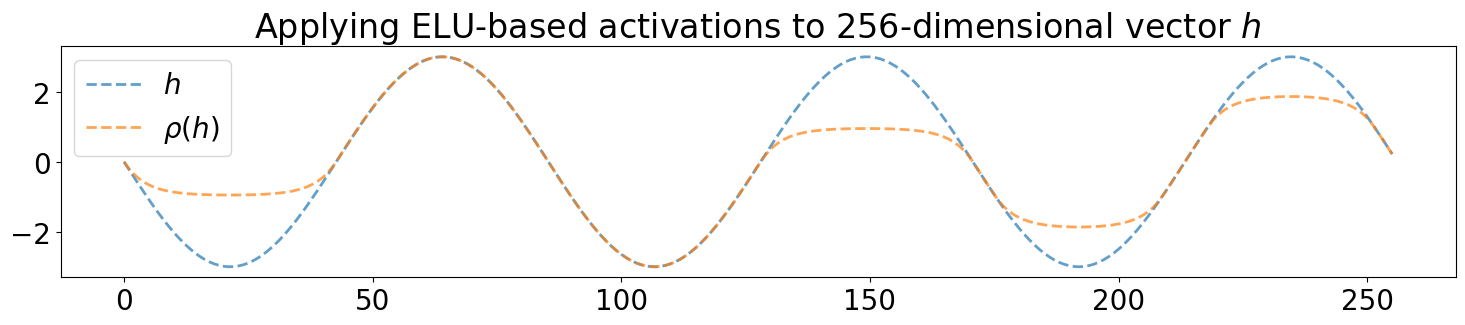

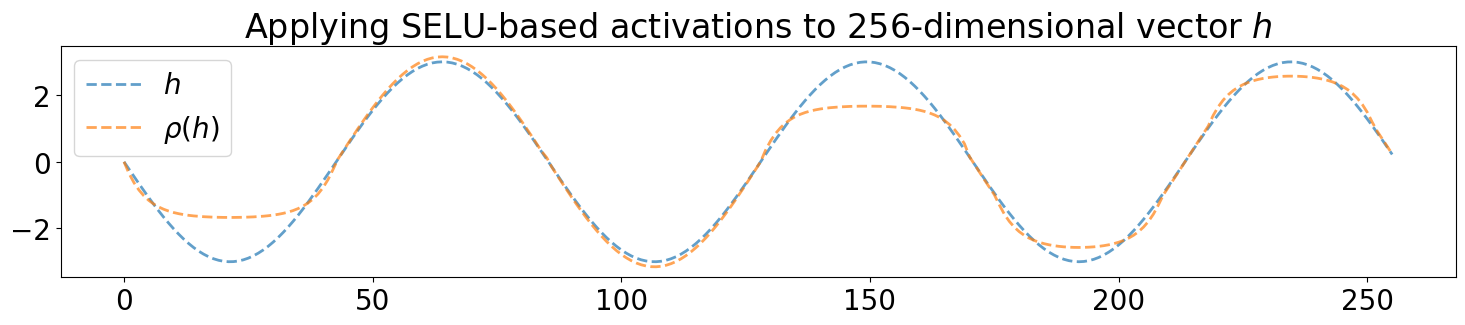

In [ ]:
for activation in ["linear", "ReLU", "ELU", "SELU"]:
    plot_applied_activation(activation, save_pdf=True)

### Monotonicity indicator


In [ ]:
# | export


def get_monotonicity_indicator(
    monotonicity_indicator: ArrayLike,
    *,
    input_shape: Tuple[int, ...],
    units: int,
) -> TensorLike:
    # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = np.array(monotonicity_indicator)
    if len(monotonicity_indicator.shape) < 2:
        monotonicity_indicator = np.reshape(monotonicity_indicator, (-1, 1))
    elif len(monotonicity_indicator.shape) > 2:
        raise ValueError(
            f"monotonicity_indicator has rank greater than 2: {monotonicity_indicator.shape}"
        )

    monotonicity_indicator_broadcasted = np.broadcast_to(
        monotonicity_indicator, shape=(input_shape[-1], units)
    )

    if not np.all(
        (monotonicity_indicator == -1)
        | (monotonicity_indicator == 0)
        | (monotonicity_indicator == 1)
    ):
        raise ValueError(
            f"Each element of monotonicity_indicator must be one of -1, 0, 1, but it is: '{monotonicity_indicator}'"
        )
    return monotonicity_indicator

In [ ]:
input_shape = (13, 2)
units = 3

layer = Dense(units=units)
layer.build(input_shape=input_shape)

for monotonicity_indicator in [
    1,
    [1],
    [1, 1],
    np.ones((2,)),
    np.ones((2, 1)),
    np.ones((2, 3)),
]:
    expected = np.ones((2, 3))
    actual = get_monotonicity_indicator(
        monotonicity_indicator, input_shape=(13, 2), units=3
    )

    # rank is 2
    assert len(actual.shape) == 2
    # it is broadcastable to the kernel shape of (input_shape[-1], units)
    np.testing.assert_array_equal(np.broadcast_to(actual, (2, 3)), expected)

In [ ]:
expected = [[1], [0], [-1]]
actual = get_monotonicity_indicator([1, 0, -1], input_shape=(13, 3), units=4)
np.testing.assert_array_equal(actual, expected)

In [ ]:
with pytest.raises(ValueError) as e:
    get_monotonicity_indicator([0, 1, -1], input_shape=(13, 2), units=3)
assert e.value.args == (
    "operands could not be broadcast together with remapped shapes [original->remapped]: (3,1)  and requested shape (2,3)",
)

In [ ]:
# | export


def apply_monotonicity_indicator_to_kernel(
    kernel: tf.Variable,
    monotonicity_indicator: ArrayLike,
) -> TensorLike:
    # convert to tensor if needed and make it broadcastable to the kernel
    monotonicity_indicator = tf.convert_to_tensor(monotonicity_indicator)

    # absolute value of the kernel
    abs_kernel = tf.abs(kernel)

    # replace original kernel values for positive or negative ones where needed
    xs = tf.where(
        monotonicity_indicator == 1,
        abs_kernel,
        kernel,
    )
    xs = tf.where(monotonicity_indicator == -1, -abs_kernel, xs)

    return xs


@contextmanager
def replace_kernel_using_monotonicity_indicator(
    layer: tf.keras.layers.Dense,
    monotonicity_indicator: TensorLike,
) -> Generator[None, None, None]:
    old_kernel = layer.kernel

    layer.kernel = apply_monotonicity_indicator_to_kernel(
        layer.kernel, monotonicity_indicator
    )
    try:
        yield
    finally:
        layer.kernel = old_kernel

In [ ]:
def display_kernel(kernel: Union[tf.Variable, np.typing.NDArray[float]]) -> None:
    cm = sns.color_palette("coolwarm_r", as_cmap=True)

    df = pd.DataFrame(kernel)

    display(
        df.style.format("{:.2f}").background_gradient(cmap=cm, vmin=-1e-8, vmax=1e-8)
    )

In [ ]:
tf.keras.utils.set_random_seed(42)

units = 18
input_len = 7

layer = tf.keras.layers.Dense(units=units)

input_shape = (input_len,)
layer.build(input_shape=input_shape)

print("Original kernel:")
display_kernel(layer.kernel)

print("Kernel after applying monotocity indicator 1 for all values:")
monotonicity_indicator = get_monotonicity_indicator(
    1, input_shape=input_shape, units=units
)
with replace_kernel_using_monotonicity_indicator(layer, monotonicity_indicator):
    display_kernel(layer.kernel)

Original kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,-0.14,0.44,-0.41,0.15,0.46,-0.33,0.02,0.13,-0.41,-0.05,0.46,-0.03,0.00,0.26,-0.47,-0.30
1,0.01,-0.42,-0.45,0.34,0.41,-0.23,0.35,-0.36,-0.04,0.06,0.07,-0.29,-0.28,0.48,-0.38,-0.06,-0.23,-0.37
2,0.23,-0.31,0.18,0.15,-0.45,0.06,-0.16,-0.11,0.45,-0.09,0.03,-0.24,-0.37,0.21,0.11,0.01,-0.46,-0.37
3,0.29,0.36,-0.07,-0.18,-0.46,-0.45,0.25,0.32,-0.12,0.22,-0.18,0.27,-0.18,-0.07,0.35,0.32,0.18,0.39
4,0.35,-0.27,0.13,-0.40,0.44,0.21,0.06,-0.31,-0.30,0.46,-0.44,-0.18,-0.26,-0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,-0.02,-0.36,0.39,-0.13,0.30,0.35,-0.12,-0.43,0.44,0.32,0.06,-0.30,-0.29,0.24,-0.44,-0.13
6,0.38,-0.04,-0.30,0.17,-0.03,0.37,-0.03,-0.18,0.42,-0.39,-0.33,-0.19,0.02,-0.41,-0.44,0.42,0.38,-0.21


Kernel after applying monotocity indicator 1 for all values:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,0.14,0.44,0.41,0.15,0.46,0.33,0.02,0.13,0.41,0.05,0.46,0.03,0.00,0.26,0.47,0.30
1,0.01,0.42,0.45,0.34,0.41,0.23,0.35,0.36,0.04,0.06,0.07,0.29,0.28,0.48,0.38,0.06,0.23,0.37
2,0.23,0.31,0.18,0.15,0.45,0.06,0.16,0.11,0.45,0.09,0.03,0.24,0.37,0.21,0.11,0.01,0.46,0.37
3,0.29,0.36,0.07,0.18,0.46,0.45,0.25,0.32,0.12,0.22,0.18,0.27,0.18,0.07,0.35,0.32,0.18,0.39
4,0.35,0.27,0.13,0.40,0.44,0.21,0.06,0.31,0.30,0.46,0.44,0.18,0.26,0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,0.02,0.36,0.39,0.13,0.30,0.35,0.12,0.43,0.44,0.32,0.06,0.30,0.29,0.24,0.44,0.13
6,0.38,0.04,0.30,0.17,0.03,0.37,0.03,0.18,0.42,0.39,0.33,0.19,0.02,0.41,0.44,0.42,0.38,0.21


In [ ]:
monotonicity_indicator = [1] * 2 + [-1] * 2 + [0] * (input_shape[0] - 4)
monotonicity_indicator = get_monotonicity_indicator(
    monotonicity_indicator, input_shape=input_shape, units=units
)

print("Monotocity indicator:")
display_kernel(monotonicity_indicator)

print("Kernel after applying the monotocity indicator:")
with replace_kernel_using_monotonicity_indicator(layer, monotonicity_indicator):
    display_kernel(layer.kernel)

Monotocity indicator:


,0
0,1.00
1,1.00
2,-1.00
3,-1.00
4,0.00
5,0.00
6,0.00


Kernel after applying the monotocity indicator:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.35,0.16,0.14,0.44,0.41,0.15,0.46,0.33,0.02,0.13,0.41,0.05,0.46,0.03,0.00,0.26,0.47,0.30
1,0.01,0.42,0.45,0.34,0.41,0.23,0.35,0.36,0.04,0.06,0.07,0.29,0.28,0.48,0.38,0.06,0.23,0.37
2,-0.23,-0.31,-0.18,-0.15,-0.45,-0.06,-0.16,-0.11,-0.45,-0.09,-0.03,-0.24,-0.37,-0.21,-0.11,-0.01,-0.46,-0.37
3,-0.29,-0.36,-0.07,-0.18,-0.46,-0.45,-0.25,-0.32,-0.12,-0.22,-0.18,-0.27,-0.18,-0.07,-0.35,-0.32,-0.18,-0.39
4,0.35,-0.27,0.13,-0.40,0.44,0.21,0.06,-0.31,-0.30,0.46,-0.44,-0.18,-0.26,-0.34,0.36,0.33,0.12,0.04
5,0.04,0.21,-0.02,-0.36,0.39,-0.13,0.30,0.35,-0.12,-0.43,0.44,0.32,0.06,-0.30,-0.29,0.24,-0.44,-0.13
6,0.38,-0.04,-0.30,0.17,-0.03,0.37,-0.03,-0.18,0.42,-0.39,-0.33,-0.19,0.02,-0.41,-0.44,0.42,0.38,-0.21


### Monotonic Dense Layer

This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.

In the code, the variable `monotonicity_indicator` corresponds to **t** in the figure and the variable `activation_selector` corresponds to **s**. 

Parameters `convexity_indicator` and `epsilon` are used to calculate `activation_selector` as follows:
- if `convexity_indicator` is  -1 or 1, then `activation_selector` will have all elements 0 or 1, respecively.
- if `convexity_indicator` is `None`, then `epsilon` must have a value between 0 and 1 and corresponds to the percentage of elements of `activation_selector` set to 1.

![mono-dense-layer-diagram.png](images/mono-dense-layer-diagram.png)

In [ ]:
# | export


@export
class MonoDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.keras

    This is an implementation of our Monotonic Dense Unit or Constrained Monotone Fully Connected Layer. The below is the figure from the paper for reference.

    - the parameter `monotonicity_indicator` corresponds to **t** in the figure below, and

    - parameters `is_convex`, `is_concave` and `activation_weights` are used to calculate the activation selector **s** as follows:

        - if `is_convex` or `is_concave` is **True**, then the activation selector **s** will be (`units`, 0, 0) and (0, `units`, 0), respecively.

        - if both  `is_convex` or `is_concave` is **False**, then the `activation_weights` represent ratios between $\\breve{s}$, $\\hat{s}$ and $\\tilde{s}$,
          respecively. E.g. if `activation_weights = (2, 2, 1)` and `units = 10`, then

    $$
    (\\breve{s}, \\hat{s}, \\tilde{s}) = (4, 4, 2)
    $$

    ![mono-dense-layer-diagram.png](../../../../../images/nbs/images/mono-dense-layer-diagram.png)

    """

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
        monotonicity_indicator: ArrayLike = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (7.0, 7.0, 2.0),
        **kwargs: Any,
    ):
        """Constructs a new MonoDense instance.

        Params:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed as kwargs to the constructor of `Dense`

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative or there is not exactly three components
        """
        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        if len(activation_weights) != 3:
            raise ValueError(
                f"There must be exactly three components of activation_weights, but we have this instead: {activation_weights}."
            )

        if (np.array(activation_weights) < 0).any():
            raise ValueError(
                f"Values of activation_weights must be non-negative, but we have this instead: {activation_weights}."
            )

        super(MonoDense, self).__init__(units=units, activation=None, **kwargs)

        self.units = units
        self.org_activation = activation
        self.monotonicity_indicator = monotonicity_indicator
        self.is_convex = is_convex
        self.is_concave = is_concave
        self.activation_weights = activation_weights

        (
            self.convex_activation,
            self.concave_activation,
            self.saturated_activation,
        ) = get_activation_functions(self.org_activation)

    def get_config(self) -> Dict[str, Any]:
        """Get config is used for saving the model"""
        return dict(
            units=self.units,
            activation=self.org_activation,
            monotonicity_indicator=self.monotonicity_indicator,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

    def build(self, input_shape: Tuple, *args: List[Any], **kwargs: Any) -> None:
        """Build

        Args:
            input_shape: input tensor
            args: positional arguments passed to Dense.build()
            kwargs: keyword arguments passed to Dense.build()
        """
        super(MonoDense, self).build(input_shape, *args, **kwargs)
        self.monotonicity_indicator = get_monotonicity_indicator(
            monotonicity_indicator=self.monotonicity_indicator,
            input_shape=input_shape,
            units=self.units,
        )

    def call(self, inputs: TensorLike) -> TensorLike:
        """Call

        Args:
            inputs: input tensor of shape (batch_size, ..., x_length)

        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with replace_kernel_using_monotonicity_indicator(
            self, monotonicity_indicator=self.monotonicity_indicator
        ):
            h = super(MonoDense, self).call(inputs)

        y = apply_activations(
            h,
            units=self.units,
            convex_activation=self.convex_activation,
            concave_activation=self.concave_activation,
            saturated_activation=self.saturated_activation,
            is_convex=self.is_convex,
            is_concave=self.is_concave,
            activation_weights=self.activation_weights,
        )

        return y

    @classmethod
    def create_type_1(
        cls,
        inputs: Union[TensorLike, Dict[str, TensorLike], List[TensorLike]],
        *,
        units: int,
        final_units: int,
        activation: Union[str, Callable[[TensorLike], TensorLike]],
        n_layers: int,
        final_activation: Optional[
            Union[str, Callable[[TensorLike], TensorLike]]
        ] = None,
        monotonicity_indicator: Union[int, Dict[str, int], List[int]] = 1,
        is_convex: Union[bool, Dict[str, bool], List[bool]] = False,
        is_concave: Union[bool, Dict[str, bool], List[bool]] = False,
        dropout: Optional[float] = None,
    ) -> TensorLike:
        """Builds Type-1 monotonic network

        Type-1 architecture corresponds to the standard MLP type of neural network architecture used in general, where each
        of the input features is concatenated to form one single input feature vector $\mathbf{x}$ and fed into the network,
        with the only difference being that instead of standard fully connected or dense layers, we employ monotonic dense units
        throughout. For the first (or input layer) layer, the indicator vector $\mathbf{t}$, is used to identify the monotonicity
        property of the input feature with respect to the output. Specifically, $\mathbf{t}$ is set to $1$ for those components
        in the input feature vector that are monotonically increasing and is set to $-1$ for those components that are monotonically
        decreasing and set to $0$ if the feature is non-monotonic. For the subsequent hidden layers, monotonic dense units with the
        indicator vector $\mathbf{t}$ always being set to $1$ are used in order to preserve monotonicity. Finally, depending on
        whether the problem at hand is a regression problem or a classification problem (or even a multi-task problem), an appropriate
        activation function (such as linear activation or sigmoid or softmax) to obtain the final output.

        ![mono-dense-layer-diagram.png](../../../images/nbs/images/type-1.png)

        Args:
            inputs: input tensor or a dictionary of tensors
            units: number of units in hidden layers
            final_units: number of units in the output layer
            activation: the base activation function
            n_layers: total number of layers (hidden layers plus the output layer)
            final_activation: the activation function of the final layer (typicall softmax, sigmoid or linear).
                If set to None (default value), then the linear activation is used.
            monotonicity_indicator: if an instance of dictionary, then maps names of input feature to their monotonicity
                indicator (-1 for monotonically decreasing, 1 for monotonically increasing and 0 otherwise). If int,
                then all input features are set to the same monotinicity indicator.
            is_convex: set to True if a particular input feature is convex
            is_concave: set to True if a particular inputs feature is concave
            dropout: dropout rate. If set to float greater than 0, Dropout layers are inserted after hidden layers.

        Returns:
            Output tensor

        """
        return _create_type_1(
            inputs,
            units=units,
            final_units=final_units,
            activation=activation,
            n_layers=n_layers,
            final_activation=final_activation,
            monotonicity_indicator=monotonicity_indicator,
            is_convex=is_convex,
            is_concave=is_concave,
            dropout=dropout,
        )

    @classmethod
    def create_type_2(
        cls,
        inputs: Union[TensorLike, Dict[str, TensorLike], List[TensorLike]],
        *,
        input_units: Optional[int] = None,
        units: int,
        final_units: int,
        activation: Union[str, Callable[[TensorLike], TensorLike]],
        n_layers: int,
        final_activation: Optional[
            Union[str, Callable[[TensorLike], TensorLike]]
        ] = None,
        monotonicity_indicator: Union[int, Dict[str, int], List[int]] = 1,
        is_convex: Union[bool, Dict[str, bool], List[bool]] = False,
        is_concave: Union[bool, Dict[str, bool], List[bool]] = False,
        dropout: Optional[float] = None,
    ) -> TensorLike:
        """Builds Type-2 monotonic network

        Type-2 architecture is another example of a neural network architecture that can be built employing proposed
        monotonic dense blocks. The difference when compared to the architecture described above lies in the way input
        features are fed into the hidden layers of neural network architecture. Instead of concatenating the features
        directly, this architecture provides flexibility to employ any form of complex feature extractors for the
        non-monotonic features and use the extracted feature vectors as inputs. Another difference is that each monotonic
        input is passed through separate monotonic dense units. This provides an advantage since depending on whether the
        input is completely concave or convex or both, we can adjust the activation selection vector $\mathbf{s}$ appropriately
        along with an appropriate value for the indicator vector $\mathbf{t}$. Thus, each of the monotonic input features has
        a separate monotonic dense layer associated with it. Thus as the major difference to the above-mentioned architecture,
        we concatenate the feature vectors instead of concatenating the inputs directly. The subsequent parts of the network are
        similar to the architecture described above wherein for the rest of the hidden monotonic dense units, the indicator vector
        $\mathbf{t}$ is always set to $1$ to preserve monotonicity.

        ![mono-dense-layer-diagram.png](../../../images/nbs/images/type-2.png)

        Args:
            inputs: input tensor or a dictionary of tensors
            input_units: used to preprocess features before entering the common mono block
            units: number of units in hidden layers
            final_units: number of units in the output layer
            activation: the base activation function
            n_layers: total number of layers (hidden layers plus the output layer)
            final_activation: the activation function of the final layer (typicall softmax, sigmoid or linear).
                If set to None (default value), then the linear activation is used.
            monotonicity_indicator: if an instance of dictionary, then maps names of input feature to their monotonicity
                indicator (-1 for monotonically decreasing, 1 for monotonically increasing and 0 otherwise). If int,
                then all input features are set to the same monotinicity indicator.
            is_convex: set to True if a particular input feature is convex
            is_concave: set to True if a particular inputs feature is concave
            dropout: dropout rate. If set to float greater than 0, Dropout layers are inserted after hidden layers.

        Returns:
            Output tensor

        """
        return _create_type_2(
            inputs,
            input_units=input_units,
            units=units,
            final_units=final_units,
            activation=activation,
            n_layers=n_layers,
            final_activation=final_activation,
            monotonicity_indicator=monotonicity_indicator,
            is_convex=is_convex,
            is_concave=is_concave,
            dropout=dropout,
        )

In [ ]:
units = 18
activation = "relu"
batch_size = 9
x_len = 11

x = np.random.default_rng(42).normal(size=(batch_size, x_len))

tf.keras.utils.set_random_seed(42)

for monotonicity_indicator in [
    [1] * 4 + [0] * 4 + [-1] * 3,
    1,
    np.ones((x_len,)),
    -1,
    -np.ones((x_len,)),
]:
    print("*" * 120)
    mono_layer = MonoDense(
        units=units,
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        activation_weights=(7, 7, 4),
    )
    print("input:")
    display_kernel(x)

    y = mono_layer(x)
    print(f"monotonicity_indicator = {monotonicity_indicator}")
    display_kernel(mono_layer.monotonicity_indicator)

    print("kernel:")
    with replace_kernel_using_monotonicity_indicator(
        mono_layer, mono_layer.monotonicity_indicator
    ):
        display_kernel(mono_layer.kernel)

    print("output:")
    display_kernel(y)
print("ok")

************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,0.00
5,0.00
6,0.00
7,0.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.33,0.15,0.13,0.41,0.38,0.14,0.43,0.30,0.02,0.12,0.38,0.05,0.42,0.03,0.00,0.24,0.44,0.28
1,0.01,0.39,0.42,0.32,0.38,0.22,0.33,0.34,0.03,0.06,0.06,0.27,0.26,0.45,0.35,0.05,0.21,0.34
2,0.21,0.29,0.16,0.14,0.42,0.06,0.15,0.10,0.41,0.08,0.03,0.22,0.34,0.20,0.11,0.01,0.43,0.35
3,0.27,0.33,0.06,0.17,0.42,0.42,0.24,0.30,0.11,0.20,0.17,0.25,0.17,0.07,0.32,0.30,0.17,0.36
4,0.32,-0.25,0.12,-0.37,0.41,0.20,0.06,-0.28,-0.27,0.43,-0.41,-0.17,-0.24,-0.31,0.33,0.31,0.11,0.03
5,0.04,0.19,-0.02,-0.34,0.36,-0.12,0.28,0.32,-0.11,-0.40,0.41,0.30,0.06,-0.28,-0.27,0.23,-0.41,-0.12
6,0.35,-0.04,-0.28,0.16,-0.03,0.35,-0.03,-0.16,0.39,-0.36,-0.31,-0.18,0.02,-0.38,-0.40,0.39,0.35,-0.19
7,0.33,-0.34,0.11,-0.29,0.25,-0.21,0.11,0.08,-0.19,-0.39,0.01,0.10,0.39,-0.25,-0.37,-0.27,0.04,0.34
8,-0.27,-0.09,-0.02,-0.45,-0.16,-0.12,-0.09,-0.43,-0.36,-0.09,-0.23,-0.42,-0.28,-0.24,-0.30,-0.31,-0.07,-0.07
9,-0.38,-0.34,-0.44,-0.42,-0.32,-0.06,-0.27,-0.28,-0.22,-0.05,-0.08,-0.07,-0.21,-0.39,-0.01,-0.26,-0.24,-0.42


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.01,0.40,0.00,1.38,0.00,0.10,0.00,-0.00,-0.00,-0.13,-0.00,-0.26,-0.00,-0.00,-0.55,-0.52,0.79,0.64
1,0.45,1.02,0.96,0.71,1.22,0.00,0.86,-0.00,-0.00,-0.09,-0.00,-0.00,-0.00,-0.00,0.26,-0.17,0.54,1.00
2,0.30,0.00,0.33,0.00,0.41,0.00,0.42,-0.53,-0.89,-0.29,-0.23,-0.84,-0.16,-0.93,-0.90,0.08,0.37,0.08
3,0.21,0.26,0.33,0.42,0.00,0.00,0.00,-0.16,-0.00,-0.61,-0.53,-0.07,-0.00,-0.00,-0.55,-0.66,0.83,0.78
4,1.38,0.49,0.70,0.82,1.47,0.54,0.63,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.73,0.97,0.94,0.91
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.86,-0.25,-0.00,-1.57,-1.19,-0.61,-0.23,0.13,-1.00,0.50,-0.06
6,0.00,0.00,0.00,0.17,0.00,0.00,0.00,-0.15,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.06,-1.00,0.00,0.12
7,0.00,0.96,0.35,0.93,0.00,0.32,0.17,-0.00,-0.00,-0.00,-0.00,-0.00,-0.17,-0.00,0.67,0.06,0.12,0.17
8,0.00,1.33,0.92,1.63,0.52,0.00,0.66,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.23,0.18,0.81


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = 1


,0
0,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.44,0.02,0.24,0.22,0.29,0.35,0.18,0.03,0.39,0.17,0.25,0.02,0.10,0.13,0.00,0.42,0.21,0.31
1,0.35,0.06,0.26,0.42,0.05,0.41,0.16,0.33,0.03,0.26,0.11,0.03,0.23,0.04,0.37,0.27,0.32,0.40
2,0.37,0.30,0.36,0.14,0.21,0.40,0.01,0.28,0.16,0.44,0.43,0.23,0.27,0.22,0.23,0.25,0.43,0.05
3,0.32,0.25,0.05,0.45,0.08,0.18,0.26,0.24,0.34,0.07,0.07,0.14,0.04,0.19,0.29,0.23,0.43,0.09
4,0.36,0.05,0.20,0.41,0.38,0.29,0.01,0.44,0.17,0.04,0.31,0.34,0.29,0.16,0.25,0.18,0.01,0.28
5,0.34,0.31,0.38,0.34,0.08,0.40,0.15,0.16,0.14,0.25,0.15,0.20,0.10,0.06,0.44,0.19,0.42,0.21
6,0.01,0.38,0.43,0.18,0.00,0.43,0.45,0.28,0.25,0.18,0.03,0.26,0.22,0.26,0.08,0.23,0.45,0.42
7,0.04,0.12,0.28,0.17,0.11,0.00,0.15,0.24,0.05,0.05,0.27,0.32,0.33,0.11,0.09,0.40,0.19,0.06
8,0.30,0.17,0.21,0.42,0.21,0.29,0.19,0.38,0.03,0.34,0.32,0.30,0.34,0.15,0.28,0.11,0.44,0.19
9,0.10,0.10,0.35,0.32,0.24,0.28,0.30,0.28,0.10,0.12,0.30,0.41,0.15,0.00,0.10,0.40,0.18,0.24


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,-0.93,-0.00,-0.07,-0.58,-0.88,-0.58,-0.00,-0.87,-0.49,-0.05,-1.00
1,0.73,0.10,0.22,0.18,0.18,0.16,0.00,-0.23,-0.00,-0.00,-0.00,-0.09,-0.00,-0.00,0.16,0.47,0.53,-0.27
2,1.15,0.36,0.82,1.20,0.80,1.06,0.61,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.53,0.61,1.00,0.94
3,0.00,0.45,0.28,0.00,0.00,0.11,0.14,-0.00,-0.21,-0.00,-0.00,-0.00,-0.00,-0.00,0.15,0.08,0.72,-0.08
4,0.34,0.19,0.36,0.05,0.15,0.30,0.00,-0.00,-0.00,-0.08,-0.00,-0.00,-0.00,-0.00,0.06,0.38,0.04,0.14
5,0.00,0.00,0.26,0.00,0.67,0.05,0.00,-0.00,-0.16,-0.00,-0.00,-0.00,-0.00,-0.00,-0.08,0.30,-0.17,-0.17
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.76,-0.68,-0.28,-0.11,-0.37,-0.42,-0.40,-0.88,-0.41,-0.67,-1.00
7,0.01,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.17,-0.04,-0.57,-0.82,-0.50,-0.22,-0.07,-0.62,-0.13,-0.18
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.32,-0.35,-0.39,-0.77,-1.63,-1.12,-0.60,-0.47,-0.99,-1.00,-1.00


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


,0
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
5,1.00
6,1.00
7,1.00
8,1.00
9,1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.31,0.02,0.11,0.29,0.10,0.33,0.37,0.06,0.39,0.35,0.15,0.13,0.15,0.45,0.07,0.19,0.03,0.06
1,0.12,0.02,0.06,0.41,0.32,0.24,0.34,0.28,0.22,0.06,0.33,0.27,0.25,0.23,0.43,0.09,0.45,0.27
2,0.19,0.11,0.19,0.25,0.07,0.42,0.32,0.35,0.15,0.05,0.00,0.24,0.22,0.39,0.44,0.11,0.19,0.10
3,0.15,0.37,0.21,0.41,0.25,0.04,0.37,0.04,0.05,0.22,0.31,0.35,0.35,0.08,0.38,0.01,0.25,0.29
4,0.17,0.45,0.24,0.32,0.01,0.00,0.19,0.34,0.17,0.19,0.18,0.34,0.02,0.24,0.03,0.41,0.26,0.00
5,0.29,0.10,0.07,0.34,0.04,0.30,0.39,0.27,0.39,0.16,0.33,0.45,0.06,0.19,0.23,0.04,0.36,0.04
6,0.13,0.15,0.22,0.40,0.14,0.30,0.11,0.45,0.14,0.17,0.26,0.16,0.36,0.10,0.17,0.32,0.14,0.08
7,0.25,0.25,0.24,0.45,0.17,0.45,0.30,0.35,0.41,0.40,0.11,0.26,0.32,0.08,0.22,0.34,0.05,0.09
8,0.16,0.27,0.10,0.23,0.08,0.21,0.19,0.16,0.06,0.04,0.17,0.05,0.39,0.11,0.26,0.25,0.13,0.05
9,0.17,0.17,0.00,0.13,0.12,0.03,0.39,0.11,0.01,0.29,0.43,0.20,0.21,0.43,0.39,0.18,0.19,0.27


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.00,0.00,0.08,0.00,0.00,0.00,0.00,-0.82,-0.58,-0.32,-1.07,-1.09,-0.00,-0.63,-0.21,-0.74,-1.00,-0.15
1,0.36,0.00,0.00,0.51,0.11,0.72,0.76,-0.12,-0.00,-0.00,-0.05,-0.00,-0.00,-0.00,0.56,-0.34,0.13,0.22
2,0.72,0.68,0.32,1.10,0.10,0.84,0.68,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.20,0.97,0.33,-0.07
3,0.00,0.00,0.36,0.35,0.36,0.82,0.00,-0.00,-0.00,-0.19,-0.29,-0.13,-0.00,-0.20,0.67,0.20,-0.00,0.14
4,0.18,0.14,0.26,0.68,0.09,0.38,0.36,-0.00,-0.00,-0.00,-0.00,-0.00,-0.07,-0.00,0.14,0.15,0.33,0.10
5,0.01,0.55,0.50,0.00,0.00,0.21,0.00,-0.00,-0.27,-0.00,-0.44,-0.25,-0.00,-0.00,0.44,0.83,-0.24,-0.01
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.89,-0.85,-0.48,-0.77,-0.90,-0.21,-0.30,-0.09,-0.69,-0.83,-0.03
7,0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.78,-0.59,-0.65,-0.21,-0.55,-0.19,-0.37,-0.17,-0.71,-0.10,0.03
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.24,-0.48,-0.95,-1.13,-0.71,-1.40,-0.30,-0.76,-1.00,-0.47,-0.39


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = -1


,0
0,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.29,-0.12,-0.00,-0.17,-0.33,-0.17,-0.33,-0.36,-0.28,-0.16,-0.24,-0.22,-0.10,-0.13,-0.02,-0.38,-0.23,-0.02
1,-0.36,-0.13,-0.05,-0.07,-0.41,-0.30,-0.38,-0.06,-0.40,-0.42,-0.44,-0.03,-0.27,-0.03,-0.32,-0.31,-0.35,-0.40
2,-0.30,-0.07,-0.40,-0.06,-0.10,-0.21,-0.16,-0.22,-0.06,-0.36,-0.40,-0.42,-0.23,-0.22,-0.20,-0.33,-0.45,-0.06
3,-0.05,-0.08,-0.07,-0.30,-0.44,-0.23,-0.40,-0.25,-0.13,-0.31,-0.11,-0.13,-0.13,-0.34,-0.15,-0.05,-0.36,-0.13
4,-0.45,-0.34,-0.41,-0.39,-0.15,-0.10,-0.40,-0.32,-0.19,-0.13,-0.29,-0.39,-0.43,-0.29,-0.13,-0.05,-0.39,-0.01
5,-0.09,-0.38,-0.00,-0.12,-0.07,-0.42,-0.01,-0.12,-0.26,-0.28,-0.16,-0.06,-0.08,-0.43,-0.23,-0.28,-0.28,-0.07
6,-0.34,-0.38,-0.15,-0.44,-0.41,-0.19,-0.25,-0.41,-0.34,-0.22,-0.43,-0.36,-0.25,-0.28,-0.06,-0.12,-0.15,-0.16
7,-0.17,-0.39,-0.40,-0.26,-0.40,-0.20,-0.10,-0.14,-0.42,-0.21,-0.18,-0.25,-0.15,-0.21,-0.13,-0.41,-0.14,-0.14
8,-0.38,-0.03,-0.10,-0.21,-0.13,-0.04,-0.19,-0.00,-0.09,-0.38,-0.01,-0.27,-0.24,-0.24,-0.13,-0.18,-0.37,-0.21
9,-0.43,-0.08,-0.20,-0.29,-0.10,-0.27,-0.08,-0.43,-0.22,-0.37,-0.27,-0.24,-0.15,-0.22,-0.01,-0.45,-0.35,-0.31


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.05,0.88,0.59,0.61,0.00,0.70,0.64,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.24,0.74,1.00,0.55
1,0.27,0.26,0.00,0.41,0.00,0.00,0.00,-0.00,-0.23,-0.34,-0.21,-0.20,-0.00,-0.02,-0.04,-0.82,-0.52,-0.02
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.36,-0.77,-0.71,-0.39,-1.00,-0.82,-0.67,-0.11,-0.74,-0.97,-0.31
3,0.00,0.00,0.00,0.00,0.00,0.01,0.00,-0.00,-0.16,-0.50,-0.38,-0.33,-0.20,-0.00,-0.39,-0.20,-0.12,-0.36
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.45,-0.46,-0.00,-0.84,-0.48,-0.36,-0.13,-0.08,-0.28,-0.33,0.13
5,0.00,0.02,0.00,0.00,0.12,0.33,0.00,-0.41,-0.00,-0.44,-0.33,-0.90,-0.56,-0.04,-0.24,-0.27,-0.48,-0.16
6,0.74,1.20,0.11,0.90,0.84,0.65,0.87,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.60,0.01,0.53,0.12
7,0.47,0.89,0.91,0.62,0.26,0.37,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.07,0.61,0.29,0.01
8,1.30,1.17,0.98,1.61,1.09,0.59,0.65,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.09,0.93,0.95,0.81


************************************************************************************************************************
input:


,0,1,2,3,4,5,6,7,8,9,10
0,0.30,-1.04,0.75,0.94,-1.95,-1.30,0.13,-0.32,-0.02,-0.85,0.88
1,0.78,0.07,1.13,0.47,-0.86,0.37,-0.96,0.88,-0.05,-0.18,-0.68
2,1.22,-0.15,-0.43,-0.35,0.53,0.37,0.41,0.43,2.14,-0.41,-0.51
3,-0.81,0.62,1.13,-0.11,-0.84,-0.82,0.65,0.74,0.54,-0.67,0.23
4,0.12,0.22,0.87,0.22,0.68,0.07,0.29,0.63,-1.46,-0.32,-0.47
5,-0.64,-0.28,1.49,-0.87,0.97,-1.68,-0.33,0.16,0.59,0.71,0.79
6,-0.35,-0.46,0.86,-0.19,-1.28,-1.13,-0.92,0.50,0.14,0.69,-0.43
7,0.16,0.63,-0.31,0.46,-0.66,-0.36,-0.38,-1.20,0.49,-0.47,0.01
8,0.48,0.45,0.67,-0.10,-0.42,-0.08,-1.69,-1.45,-1.32,-1.00,0.40


monotonicity_indicator = [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


,0
0,-1.00
1,-1.00
2,-1.00
3,-1.00
4,-1.00
5,-1.00
6,-1.00
7,-1.00
8,-1.00
9,-1.00


kernel:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.45,-0.28,-0.30,-0.41,-0.17,-0.39,-0.22,-0.45,-0.28,-0.40,-0.18,-0.20,-0.16,-0.18,-0.10,-0.13,-0.14,-0.35
1,-0.09,-0.27,-0.09,-0.14,-0.02,-0.36,-0.21,-0.05,-0.05,-0.01,-0.02,-0.45,-0.03,-0.09,-0.01,-0.05,-0.39,-0.05
2,-0.17,-0.15,-0.37,-0.35,-0.32,-0.03,-0.24,-0.31,-0.35,-0.41,-0.00,-0.37,-0.18,-0.26,-0.09,-0.44,-0.09,-0.17
3,-0.42,-0.17,-0.11,-0.31,-0.32,-0.11,-0.20,-0.10,-0.34,-0.15,-0.24,-0.22,-0.22,-0.08,-0.40,-0.02,-0.23,-0.38
4,-0.13,-0.17,-0.06,-0.13,-0.32,-0.42,-0.28,-0.44,-0.03,-0.26,-0.38,-0.45,-0.08,-0.06,-0.04,-0.33,-0.27,-0.38
5,-0.32,-0.38,-0.19,-0.19,-0.33,-0.01,-0.15,-0.08,-0.31,-0.27,-0.07,-0.11,-0.21,-0.22,-0.18,-0.27,-0.19,-0.15
6,-0.30,-0.16,-0.09,-0.25,-0.23,-0.44,-0.25,-0.16,-0.05,-0.13,-0.20,-0.09,-0.14,-0.18,-0.15,-0.22,-0.37,-0.38
7,-0.20,-0.14,-0.12,-0.10,-0.42,-0.42,-0.14,-0.04,-0.44,-0.11,-0.10,-0.17,-0.06,-0.29,-0.22,-0.24,-0.01,-0.45
8,-0.31,-0.11,-0.16,-0.21,-0.16,-0.39,-0.12,-0.36,-0.36,-0.29,-0.24,-0.24,-0.20,-0.18,-0.33,-0.39,-0.20,-0.02
9,-0.41,-0.14,-0.12,-0.21,-0.01,-0.37,-0.03,-0.22,-0.38,-0.22,-0.09,-0.22,-0.19,-0.17,-0.13,-0.32,-0.30,-0.21


output:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.20,0.84,0.11,0.00,0.55,1.24,0.55,-0.00,-0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.20,0.98,1.00,0.30
1,0.00,0.00,0.00,0.00,0.00,0.19,0.00,-0.14,-0.87,-0.50,-0.00,-0.34,-0.28,-0.53,-0.24,-0.34,0.23,-0.09
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.34,-0.82,-1.02,-0.75,-0.74,-0.56,-0.68,-0.71,-1.00,-0.65,-0.56
3,0.23,0.18,0.00,0.00,0.00,0.00,0.00,-0.00,-0.27,-0.00,-0.00,-0.21,-0.00,-0.28,-0.21,-0.25,0.02,0.00
4,0.09,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,-0.00,-0.14,-0.00,-0.50,-0.01,-0.25,0.23,-0.20,-0.14,-0.66
5,0.18,0.49,0.00,0.00,0.03,0.00,0.00,-0.79,-0.36,-0.49,-0.39,-0.69,-0.00,-0.09,0.08,-0.84,0.10,-0.25
6,0.64,0.77,0.08,0.50,0.62,0.79,0.68,-0.00,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,0.28,0.24,0.86,0.87
7,0.32,0.24,0.23,0.18,0.76,0.62,0.28,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.13,0.73,0.09,0.87
8,1.23,0.50,0.27,0.51,1.08,2.00,0.60,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,1.00,1.00,1.00


ok


In [ ]:
x = Input(shape=(5, 7, 8))

layer = MonoDense(
    units=12,
    activation=activation,
    monotonicity_indicator=[1] * 3 + [-1] * 3 + [0] * 2,
    is_convex=False,
    is_concave=False,
)

y = layer(x)

model = Model(inputs=x, outputs=y)

model.summary()

display_kernel(layer.monotonicity_indicator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 mono_dense_5 (MonoDense)    (None, 5, 7, 12)          108       
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


,0
0,1.00
1,1.00
2,1.00
3,-1.00
4,-1.00
5,-1.00
6,0.00
7,0.00


### Mono blocks

In [ ]:
# | export


def _create_mono_block(
    *,
    units: List[int],
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    monotonicity_indicator: TensorLike = 1,
    is_convex: bool = False,
    is_concave: bool = False,
    dropout: Optional[float] = None,
) -> Callable[[TensorLike], TensorLike]:
    def create_mono_block_inner(
        x: TensorLike,
        *,
        units: List[int] = units,
        activation: Union[str, Callable[[TensorLike], TensorLike]] = activation,
        monotonicity_indicator: TensorLike = monotonicity_indicator,
        is_convex: bool = is_convex,
        is_concave: bool = is_concave,
    ) -> TensorLike:
        if len(units) == 0:
            return x

        y = x
        for i in range(len(units)):
            y = MonoDense(
                units=units[i],
                activation=activation if i < len(units) - 1 else None,
                monotonicity_indicator=monotonicity_indicator if i == 0 else 1,
                is_convex=is_convex,
                is_concave=is_concave,
                name=f"mono_dense_{i}"
                + ("_increasing" if i != 0 else "")
                + ("_convex" if is_convex else "")
                + ("_concave" if is_concave else ""),
            )(y)
            if (i < len(units) - 1) and dropout:
                y = Dropout(dropout)(y)

        return y

    return create_mono_block_inner

In [ ]:
x = Input(shape=(5, 7, 8))

# monotonicity indicator must be broadcastable to input shape, so we use the vector of length 8
monotonicity_indicator = [1] * 3 + [0] * 2 + [-1] * 3

# this mono block has 4 layers with the final one having the shape
mono_block = _create_mono_block(
    units=[16] * 3 + [3],
    monotonicity_indicator=monotonicity_indicator,
    activation="elu",
    dropout=0.1,
)
y = mono_block(x)
model = Model(inputs=x, outputs=y)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonoDense)]
assert not (mono_layers[0].monotonicity_indicator == 1).all()
for mono_layer in mono_layers[1:]:
    assert (mono_layer.monotonicity_indicator == 1).all()

for mono_layer in mono_layers[:-1]:
    assert mono_layer.org_activation == "elu"
assert mono_layers[-1].org_activation == None

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7, 8)]         0         
                                                                 
 mono_dense_0 (MonoDense)    (None, 5, 7, 16)          144       
                                                                 
 dropout (Dropout)           (None, 5, 7, 16)          0         
                                                                 
 mono_dense_1_increasing (Mo  (None, 5, 7, 16)         272       
 noDense)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 5, 7, 16)          0         
                                                                 
 mono_dense_2_increasing (Mo  (None, 5, 7, 16)         272       
 noDense)                                                  

In [ ]:
# | export

T = TypeVar("T")


def _prepare_mono_input_n_param(
    inputs: Union[TensorLike, Dict[str, TensorLike], List[TensorLike]],
    param: Union[T, Dict[str, T], List[T]],
) -> Tuple[List[TensorLike], List[T], List[str]]:
    if isinstance(inputs, list):
        if isinstance(param, int):
            param = [param] * len(inputs)  # type: ignore
        elif isinstance(param, list):
            if len(inputs) != len(param):
                raise ValueError(f"{len(inputs)} != {len(param)}")
        else:
            raise ValueError(f"Uncompatible types: {type(inputs)=}, {type(param)=}")
        sorted_feature_names = [f"{i}" for i in range(len(inputs))]

    elif isinstance(inputs, dict):
        sorted_feature_names = sorted(inputs.keys())

        if isinstance(param, int):
            param = [param] * len(inputs)  # type: ignore
        elif isinstance(param, dict):
            if set(param.keys()) != set(sorted_feature_names):
                raise ValueError(f"{set(param.keys())} != {set(sorted_feature_names)}")
            else:
                param = [param[k] for k in sorted_feature_names]
        else:
            raise ValueError(f"Uncompatible types: {type(inputs)=}, {type(param)=}")

        inputs = [inputs[k] for k in sorted_feature_names]

    else:
        if not isinstance(param, int):
            raise ValueError(f"Uncompatible types: {type(inputs)=}, {type(param)=}")
        inputs = [inputs]
        param = [param]  # type: ignore
        sorted_feature_names = ["inputs"]

    return inputs, param, sorted_feature_names

In [ ]:
inputs = Input(name="a", shape=(1,))
param = 0

actual = _prepare_mono_input_n_param(inputs, param)
expected = [inputs], [0], ["inputs"]
assert actual == expected, actual

In [ ]:
inputs = Input(name="a", shape=(1,))
param = {"a": 1}

with pytest.raises(ValueError) as e:
    actual = _prepare_mono_input_n_param(inputs, param)

e

<ExceptionInfo ValueError("Uncompatible types: type(inputs)=<class 'keras.engine.keras_tensor.KerasTensor'>, type(param)=<class 'dict'>") tblen=2>

In [ ]:
a = Input(name="a", shape=(1,))
actual = _prepare_mono_input_n_param({"a": a}, -1)
assert actual == ([a], [-1], ["a"])

In [ ]:
a = Input(name="a", shape=(1,))
b = Input(name="b", shape=(1,))

actual = _prepare_mono_input_n_param({"a": a, "b": b}, {"a": -1, "b": 1})
assert actual == ([a, b], [-1, 1], ["a", "b"])

In [ ]:
with pytest.raises(ValueError) as e:
    actual = _prepare_mono_input_n_param(
        {"a": Input(name="a", shape=(1,)), "b": Input(name="b", shape=(1,))}, {"a": -1}
    )
e

<ExceptionInfo ValueError("{'a'} != {'b', 'a'}") tblen=2>

In [ ]:
a = Input(name="a", shape=(1,))
b = Input(name="b", shape=(1,))

actual = _prepare_mono_input_n_param([a, b], [1, -1])
assert actual == ([a, b], [1, -1], ["0", "1"])

In [ ]:
a = Input(name="a", shape=(1,))
b = Input(name="b", shape=(1,))

actual = _prepare_mono_input_n_param([a, b], -1)
assert actual == ([a, b], [-1, -1], ["0", "1"])

In [ ]:
# | export


def _check_convexity_params(
    monotonicity_indicator: List[int],
    is_convex: List[bool],
    is_concave: List[bool],
    names: List[str],
) -> Tuple[bool, bool]:
    ix = [
        i for i in range(len(monotonicity_indicator)) if is_convex[i] and is_concave[i]
    ]

    if len(ix) > 0:
        raise ValueError(
            f"Parameters both convex and concave: {[names[i] for i in ix]}"
        )

    has_convex = any(is_convex)
    has_concave = any(is_concave)
    if has_convex and has_concave:
        print("WARNING: we have both convex and concave parameters")

    return has_convex, has_concave

In [ ]:
monotonicity_indicator = [-1, 0, 1]
is_convex = [True] * 3
is_concave = [False] * 3
names = list("abc")
has_convex, has_concave = _check_convexity_params(
    monotonicity_indicator, is_convex, is_concave, names
)
assert (has_convex, has_concave) == (True, False)

### Type-1 architecture

In [ ]:
# | export


@export
def _create_type_1(
    inputs: Union[TensorLike, Dict[str, TensorLike], List[TensorLike]],
    *,
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, int], List[int]] = 1,
    is_convex: Union[bool, Dict[str, bool], List[bool]] = False,
    is_concave: Union[bool, Dict[str, bool], List[bool]] = False,
    dropout: Optional[float] = None,
) -> TensorLike:
    """Builds Type-1 monotonic network

    Type-1 architecture corresponds to the standard MLP type of neural network architecture used in general, where each
    of the input features is concatenated to form one single input feature vector $\mathbf{x}$ and fed into the network,
    with the only difference being that instead of standard fully connected or dense layers, we employ monotonic dense units
    throughout. For the first (or input layer) layer, the indicator vector $\mathbf{t}$, is used to identify the monotonicity
    property of the input feature with respect to the output. Specifically, $\mathbf{t}$ is set to $1$ for those components
    in the input feature vector that are monotonically increasing and is set to $-1$ for those components that are monotonically
    decreasing and set to $0$ if the feature is non-monotonic. For the subsequent hidden layers, monotonic dense units with the
    indicator vector $\mathbf{t}$ always being set to $1$ are used in order to preserve monotonicity. Finally, depending on
    whether the problem at hand is a regression problem or a classification problem (or even a multi-task problem), an appropriate
    activation function (such as linear activation or sigmoid or softmax) to obtain the final output.

    ![mono-dense-layer-diagram.png](../../../images/nbs/images/type-1.png)

    Args:
        inputs: input tensor or a dictionary of tensors
        units: number of units in hidden layers
        final_units: number of units in the output layer
        activation: the base activation function
        n_layers: total number of layers (hidden layers plus the output layer)
        final_activation: the activation function of the final layer (typicall softmax, sigmoid or linear).
            If set to None (default value), then the linear activation is used.
        monotonicity_indicator: if an instance of dictionary, then maps names of input feature to their monotonicity
            indicator (-1 for monotonically decreasing, 1 for monotonically increasing and 0 otherwise). If int,
            then all input features are set to the same monotinicity indicator.
        is_convex: set to True if a particular input feature is convex
        is_concave: set to True if a particular inputs feature is concave
        dropout: dropout rate. If set to float greater than 0, Dropout layers are inserted after hidden layers.

    Returns:
        Output tensor

    """
    _, is_convex, _ = _prepare_mono_input_n_param(inputs, is_convex)
    _, is_concave, _ = _prepare_mono_input_n_param(inputs, is_concave)
    x, monotonicity_indicator, names = _prepare_mono_input_n_param(
        inputs, monotonicity_indicator
    )
    has_convex, has_concave = _check_convexity_params(
        monotonicity_indicator, is_convex, is_concave, names
    )

    y = tf.keras.layers.Concatenate()(x)

    y = _create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=monotonicity_indicator,
        is_convex=has_convex,
        is_concave=has_concave and not has_convex,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        y = tf.keras.activations.get(final_activation)(y)

    return y

In [ ]:
n_layers = 4

inputs = {name: Input(name=name, shape=(1,)) for name in list("abcd")}
outputs = _create_type_1(
    inputs=inputs,
    units=64,
    final_units=10,
    activation="elu",
    n_layers=n_layers,
    final_activation="softmax",
    monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
    is_convex=True,
    dropout=0.1,
)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

mono_layers = [layer for layer in model.layers if isinstance(layer, MonoDense)]
assert len(mono_layers) == n_layers

# check monotonicity indicator
np.testing.assert_array_equal(
    mono_layers[0].monotonicity_indicator, np.array([1, 0, -1, 0]).reshape((-1, 1))
)
for i in range(1, n_layers):
    assert mono_layers[i].monotonicity_indicator == 1

# check convexity and concavity
for i in range(n_layers):
    assert mono_layers[i].is_convex
    assert not mono_layers[i].is_concave

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

### Type-2 architecture

In [ ]:
monotonicity_indicator = [1, 0, -1]
input_units = 2
monotonicity_indicator = sum(
    [[abs(x)] * input_units for x in monotonicity_indicator], []
)
monotonicity_indicator

[1, 1, 0, 0, 1, 1]

In [ ]:
# | export


@export
def _create_type_2(
    inputs: Union[TensorLike, Dict[str, TensorLike], List[TensorLike]],
    *,
    input_units: Optional[int] = None,
    units: int,
    final_units: int,
    activation: Union[str, Callable[[TensorLike], TensorLike]],
    n_layers: int,
    final_activation: Optional[Union[str, Callable[[TensorLike], TensorLike]]] = None,
    monotonicity_indicator: Union[int, Dict[str, int], List[int]] = 1,
    is_convex: Union[bool, Dict[str, bool], List[bool]] = False,
    is_concave: Union[bool, Dict[str, bool], List[bool]] = False,
    dropout: Optional[float] = None,
) -> TensorLike:
    """Builds Type-2 monotonic network

    Type-2 architecture is another example of a neural network architecture that can be built employing proposed
    monotonic dense blocks. The difference when compared to the architecture described above lies in the way input
    features are fed into the hidden layers of neural network architecture. Instead of concatenating the features
    directly, this architecture provides flexibility to employ any form of complex feature extractors for the
    non-monotonic features and use the extracted feature vectors as inputs. Another difference is that each monotonic
    input is passed through separate monotonic dense units. This provides an advantage since depending on whether the
    input is completely concave or convex or both, we can adjust the activation selection vector $\mathbf{s}$ appropriately
    along with an appropriate value for the indicator vector $\mathbf{t}$. Thus, each of the monotonic input features has
    a separate monotonic dense layer associated with it. Thus as the major difference to the above-mentioned architecture,
    we concatenate the feature vectors instead of concatenating the inputs directly. The subsequent parts of the network are
    similar to the architecture described above wherein for the rest of the hidden monotonic dense units, the indicator vector
    $\mathbf{t}$ is always set to $1$ to preserve monotonicity.

    ![mono-dense-layer-diagram.png](../../../images/nbs/images/type-2.png)

    Args:
        inputs: input tensor or a dictionary of tensors
        input_units: used to preprocess features before entering the common mono block
        units: number of units in hidden layers
        final_units: number of units in the output layer
        activation: the base activation function
        n_layers: total number of layers (hidden layers plus the output layer)
        final_activation: the activation function of the final layer (typicall softmax, sigmoid or linear).
            If set to None (default value), then the linear activation is used.
        monotonicity_indicator: if an instance of dictionary, then maps names of input feature to their monotonicity
            indicator (-1 for monotonically decreasing, 1 for monotonically increasing and 0 otherwise). If int,
            then all input features are set to the same monotinicity indicator.
        is_convex: set to True if a particular input feature is convex
        is_concave: set to True if a particular inputs feature is concave
        dropout: dropout rate. If set to float greater than 0, Dropout layers are inserted after hidden layers.

    Returns:
        Output tensor

    """
    _, is_convex, _ = _prepare_mono_input_n_param(inputs, is_convex)
    _, is_concave, _ = _prepare_mono_input_n_param(inputs, is_concave)
    x, monotonicity_indicator, names = _prepare_mono_input_n_param(
        inputs, monotonicity_indicator
    )
    has_convex, has_concave = _check_convexity_params(
        monotonicity_indicator, is_convex, is_concave, names
    )

    if input_units is None:
        input_units = max(units // 4, 1)

    y = [
        (
            MonoDense(
                units=input_units,
                activation=activation,
                monotonicity_indicator=monotonicity_indicator[i],
                is_convex=is_convex[i],
                is_concave=is_concave[i],
                name=f"mono_dense_{names[i]}"
                + ("_increasing" if monotonicity_indicator[i] == 1 else "_decreasing")
                + ("_convex" if is_convex[i] else "")
                + ("_concave" if is_concave[i] else ""),
            )
            if monotonicity_indicator[i] != 0
            else (
                Dense(
                    units=input_units, activation=activation, name=f"dense_{names[i]}"
                )
            )
        )(x[i])
        for i in range(len(inputs))
    ]

    y = Concatenate(name="preprocessed_features")(y)
    monotonicity_indicator_block: List[int] = sum(
        [[abs(x)] * input_units for x in monotonicity_indicator], []
    )

    y = _create_mono_block(
        units=[units] * (n_layers - 1) + [final_units],
        activation=activation,
        monotonicity_indicator=monotonicity_indicator_block,
        is_convex=has_convex,
        is_concave=has_concave and not has_convex,
        dropout=dropout,
    )(y)

    if final_activation is not None:
        y = tf.keras.activations.get(final_activation)(y)

    return y

In [ ]:
for dropout in [False, True]:
    print("*" * 120)
    print()
    print(f"{dropout=}")
    print()
    inputs = {name: Input(name=name, shape=(1,)) for name in list("abcd")}
    outputs = _create_type_2(
        inputs,
        units=32,
        final_units=10,
        activation="elu",
        final_activation="softmax",
        n_layers=3,
        dropout=dropout,
        monotonicity_indicator=dict(a=1, b=0, c=-1, d=0),
        is_convex=dict(a=True, b=False, c=False, d=False),
        is_concave=False,
    )
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

************************************************************************************************************************

dropout=False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 a (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 b (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 d (InputLayer)                 [(None, 1)]          0

 mono_dense_2_increasing_convex  (None, 10)          330         ['dropout_7[0][0]']              
  (MonoDense)                                                                                     
                                                                                                  
 tf.nn.softmax_2 (TFOpLambda)   (None, 10)           0           ['mono_dense_2_increasing_convex[
                                                                 0][0]']                          
                                                                                                  
Total params: 2,506
Trainable params: 2,506
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# # | export

# from keras.layers import Layer

# # Optimizacija CDFHead modula s novim izračunom gubitka mreže koristeći dinamički uzrokovane vremenske trenutke na razini grupe (batch) kao dinamičke granice diskretnih grupa. Ova metoda će dodatno ubrzati treniranje modela uz očuvanje točnosti modela kao i kod trenutne implementacije koja koristi gradijent CDF-a da bi izračunala PDF i vjerojatnosti danih događaja.

# @export
# class CDFHead(Layer):
#     """Continuos Distribution Function (CDF) Head

#     This is an implementation of the Continuos Distribution Function (CDF) Head. It uses dynamically sampled time points
#     at batch level as dynamic boundaries of discrete groups. This method speeds up the training of the model while preserving
#     the accuracy of the model as in the current implementation that uses the CDF gradient to compute the PDF and probabilities
#     of given events.
    

#     """

#     def __init__(
#         self,
#         **kwargs: Any,
#     ):
#         """Constructs a new CDFHead instance.

#         This is an implementation of the Continuos Distribution Function (CDF) Head. It uses dynamically sampled time points
#         at batch level as dynamic boundaries of discrete groups. This method speeds up the training of the model while preserving
#         the accuracy of the model as in the current implementation that uses the CDF gradient to compute the PDF and probabilities
#         of given events.
    

#         Args:
#             **kwargs: passed as kwargs to the constructor of `Layer`

#         """
#         super(CDFHead, self).__init__(**kwargs)

In [ ]:
# | export

from keras.layers import Layer

# Optimizacija CDFHead modula s novim izračunom gubitka mreže koristeći dinamički uzrokovane vremenske trenutke na razini grupe (batch) kao dinamičke granice diskretnih grupa. Ova metoda će dodatno ubrzati treniranje modela uz očuvanje točnosti modela kao i kod trenutne implementacije koja koristi gradijent CDF-a da bi izračunala PDF i vjerojatnosti danih događaja.

@export
class CDFHead(Layer):
    """Continuos Distribution Function (CDF) Head

    This is an implementation of the Continuos Distribution Function (CDF) Head. It uses dynamically sampled time points
    at batch level as dynamic boundaries of discrete groups. This method speeds up the training of the model while preserving
    the accuracy of the model as in the current implementation that uses the CDF gradient to compute the PDF and probabilities
    of given events.
    

    """

    def __init__(
        self,
        **kwargs: Any,
    ):
        """Constructs a new CDFHead instance.

        This is an implementation of the Continuos Distribution Function (CDF) Head. It uses dynamically sampled time points
        at batch level as dynamic boundaries of discrete groups. This method speeds up the training of the model while preserving
        the accuracy of the model as in the current implementation that uses the CDF gradient to compute the PDF and probabilities
        of given events.
    

        Args:
            **kwargs: passed as kwargs to the constructor of `Layer`

        """
        super(CDFHead, self).__init__(**kwargs)

In [ ]:
# | export

from tensorflow.data import Dataset
from dataclasses import dataclass

@export
@dataclass
class HyperParameters:
    """Hyperparameters of a model"""
    units: int
    activation: str
    n_layers: int
    final_activation: str
    dropout: Optional[float]

@export
@dataclass
class HyperParametersRange:
    """Hyperparameters ranges of a model"""
    units: list[int]
    activation: list[str]
    n_layers: list[int]
    final_activation: list[str]
    dropout: list[Optional[float]]


@export
class FraudEstimationModel():
    pass
    """Fraud Estimation Model

    This is an implementation of the Fraud Estimation Model.
    It uses monotonic dense blocks followed by the continuous distribution function (CDF) head to estimate the probability of fraud.
    The model takes ranges of possible hyperparameters and the dataset as input and returns the best hyperparameters for the model.

    Args:
        data: dataset
        hparam_range: hyperparameters range

    """


#     def __init__(self, data: Dataset, hparam_range: HyperParametersRange) -> None:
#         """Fraud Estimation Model

#         This is an implementation of the Fraud Estimation Model.
#         It uses monotonic dense blocks followed by the continuous distribution function (CDF) head to estimate the probability of fraud.
#         The model takes ranges of possible hyperparameters and the dataset as input and returns the best hyperparameters for the model.

#         Args:
#             data: dataset
#             hparam_range: hyperparameters range

#         """
#         pass

# # export(HyperParameters, module="airt.keras.models")
# # export(HyperParametersRange, module="airt.keras.models")
# # export(FraudEstimationModela, module="airt.keras.models")
